This is a live notebook with experimental code to develop analysis investigating the correlation between features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import json

import scipy.stats as spstats
# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.ar_model import ar_select_order

import os
print(os.listdir("."))


import re
res_digit = r'[0-9]'


['debug_windowing_data.ipynb', 'testing_mlpwrapper.ipynb', 'logs', 'gait_data_features.ipynb', 'feature_development.ipynb', 'data', 'merging_dataframes.ipynb', 'data_and_processing_description.ipynb', 'featured_prediction_random_forest.ipynb', 'window_timings_and_IBI.ipynb', 'gait_data_exploration.ipynb', 'feature_correlation_analysis.ipynb', 'Analyse_results.ipynb', '.ipynb_checkpoints', 'loading_e4_data.ipynb', 'data_investigation_scratch.ipynb', 'grouping_and_crossvalidation.ipynb', 'sample-entropy-numba-impl.ipynb', 'featured_prediction.ipynb']


In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

In [4]:
from predicament.utils.config import DREEM_EEG_CHANNELS
from predicament.utils.config import FEATURED_BASE_PATH
from predicament.utils.config import WINDOWED_BASE_PATH


from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from predicament.data.features import filter_features
from prepare_evaluation_data import load_dataframe_and_config
from prepare_evaluation_data import write_dataframe_and_config


In [5]:
from predicament.utils.config import E4_CSV_FILES
from predicament.utils.config import E4_FULL_DIRPATHS
E4_FULL_DIRPATHS

{'VG_01': '../data/CARE_HOME_DATA/./VG01/E4_8921_15_44/',
 'VG_03': '../data/CARE_HOME_DATA/./VG03/E4_9921_12_16/',
 'VG_05': '../data/CARE_HOME_DATA/./VG05/E4_9921_13_24/',
 'VG_06': '../data/CARE_HOME_DATA/./VG06/E4_51021_13_33/',
 'VG_07': '../data/CARE_HOME_DATA/./VG07/E4_51021_15_39/',
 'VG_08': '../data/CARE_HOME_DATA/./VG08/E4_71021_10_42/',
 'VG_09': '../data/CARE_HOME_DATA/./VG09/E4_11221_14_46/',
 'VG_10': '../data/CARE_HOME_DATA/./VG10/E4_31221_11_17/',
 'VH_01': '../data/CARE_HOME_DATA/./VH01/E4_61021_11_03/',
 'VH_02': '../data/CARE_HOME_DATA/./VH02/E4_61021_13_59/',
 'VH_03': '../data/CARE_HOME_DATA/./VH03/E4_11221_11_22/'}

In [6]:
import matplotlib.pyplot as plt

def scatter_plot_features(featured_df, feature_names, with_jitter=False, jitter=1e-5):
    feature_data = featured_df[feature_names].to_numpy()

    if with_jitter:
        col_means = np.mean(feature_data, axis=0)
        noise = (np.random.random(feature_data.shape)*2-1)*jitter*col_means.reshape((1,-1))
        feature_data = feature_data + noise
    N,F = feature_data.shape
    fig, axgrid = plt.subplots(F,F, figsize=(10,8))
    for i in range(F):
        for j in range(F):
            if i != j:
                axgrid[i,j].scatter(feature_data[:,j],feature_data[:,i], marker='.', s=0.5)
            else:
                try:
                    axgrid[i,i].hist(feature_data[:,i])
                except:
                    print(f"Failed to histogram {i}th feature {feature_names[i]}")
                    inf_val_positions = ~np.isfinite(feature_data[:,i])
                    print(f"inf_val_positions = {inf_val_positions}")
                    axgrid[i,i].hist(feature_data[~inf_val_positions,i])
            axgrid[i,j].set_xticks([])
            axgrid[i,j].set_yticks([])

            if j == 0:
                axgrid[i,j].set_ylabel(feature_names[i], rotation='horizontal', ha='right')
            if i == F-1:
                axgrid[i,j].set_xlabel(feature_names[j], rotation='vertical')
    plt.tight_layout()

## dreem (EEG) data or E4 data



In [7]:
subdir = 'dreem_4secs'
featured_data_dir = os.path.join(FEATURED_BASE_PATH,subdir)

featured_df, featured_config = load_dataframe_and_config(
    featured_data_dir, 'featured.csv')

In [8]:
n_channels = int(featured_config['LOAD']['n_channels'])
channels = json.loads(featured_config['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(featured_config['LOAD']['participant_list'].replace("'",'"'))
Fs = int(featured_config['LOAD']['sample_rate'])
window_size = int(featured_config['LOAD']['window_size'])
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")

Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 4


In [9]:
channels

['EEG Fpz-O1', 'EEG Fpz-O2', 'EEG Fpz-F7', 'EEG Fpz-F8']

In [10]:
# features
feature_names = json.loads(featured_config['FEATURED']['feature_names'].replace("'",'"'))
print(f"feature_names= {feature_names}")

feature_names= ['Hurst_H2', 'SD2', 'MAD3', 'LempelZivEntropy[b=1][2]', 'Correlation4', 'FreqKurtosis1', 'Hurst_C0', 'Correlation2', 'LempelZivEntropy[b=1][3]', 'FreqSkewness1', 'SD3', 'Hurst_H3', 'Min0', 'MeanFreq0', 'MeanFreq1', 'MAD0', 'LyapunovExponent3', 'Correlation5', 'LyapunovExponent1', 'arCoeff0', 'Energy2', 'Hurst_C1', 'MeanFreq3', 'IQR3', 'MaxFreqInd3', 'arCoeff1', 'SD1', 'LyapunovExponent0', 'IQR0', 'IQR1', 'SampleEntropy[m=2][1]', 'IQR2', 'Hurst_H0', 'LempelZivComplexity[b=2]', 'arCoeff2', 'FreqKurtosis0', 'arCoeff12', 'Energy1', 'Min2', 'LempelZivComplexity[b=4]', 'Energy0', 'arCoeff13', 'SD0', 'arCoeff9', 'arCoeff3', 'MAD1', 'Mean3', 'Hurst_H1', 'FreqKurtosis2', 'Correlation0', 'LyapunovExponent2', 'Mean2', 'LempelZivEntropy[b=1][1]', 'MaxFreqInd1', 'FreqSkewness0', 'FreqSkewness3', 'Hurst_C3', 'Correlation3', 'Mean0', 'MaxFreqInd2', 'Mean1', 'Max2', 'Hurst_C2', 'arCoeff7', 'Min3', 'Energy3', 'FreqKurtosis3', 'LempelZivComplexity[b=1]', 'arCoeff4', 'MAD2', 'Max1', 'Sampl

In [11]:
# group features
INFO_FEATURE_GROUP.add('HRVRMSSD')
INFO_FEATURE_GROUP.add('LempelZivComplexityAlt')
stats_features = filter_features(feature_names, STATS_FEATURE_GROUP)
info_features = filter_features(feature_names, INFO_FEATURE_GROUP)#+ ['HRVRMSSD']
freq_features= filter_features(feature_names, FREQ_FEATURE_GROUP)
print(f"stats_features:\n\t{stats_features}")
print(f"info_features:\n\t{info_features}")
print(f"freq_features:\n\t{freq_features}")
type(INFO_FEATURE_GROUP)

stats_features:
	['Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'Max0', 'Max1', 'Max2', 'Max3', 'Mean0', 'Mean1', 'Mean2', 'Mean3', 'Min0', 'Min1', 'Min2', 'Min3', 'SD0', 'SD1', 'SD2', 'SD3']
info_features:
	['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]', 'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]', 'LempelZivEntropy[b=1][0]', 'LempelZivEntropy[b=1][1]', 'LempelZivEntropy[b=1][2]', 'LempelZivEntropy[b=1][3]', 'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2', 'LyapunovExponent3', 'SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]', 'arCoeff0', 'arCoeff1', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9']
fre

set

In [12]:
featured_df[stats_features].corr()

,Correlation0,Correlation1,Correlation2,Correlation3,Correlation4,Correlation5,IQR0,IQR1,IQR2,IQR3,...,Mean2,Mean3,Min0,Min1,Min2,Min3,SD0,SD1,SD2,SD3
Correlation0,1.000000,0.282032,0.140596,0.397168,0.363596,0.252270,-0.056026,-0.398147,0.082869,0.095385,...,-0.013334,0.007114,0.067542,0.465064,-0.177856,-0.161553,-0.090371,-0.438892,0.125556,0.118537
Correlation1,0.282032,1.000000,0.294913,0.627710,0.307586,0.471219,0.003285,-0.245307,0.284236,0.190252,...,0.004009,-0.007250,-0.080229,0.118008,-0.446943,-0.373874,0.000740,-0.234351,0.338955,0.244452
Correlation2,0.140596,0.294913,1.000000,0.258719,0.611957,0.516306,0.124676,0.093482,0.304096,0.000265,...,0.011266,-0.014531,-0.268315,-0.072468,-0.490900,-0.215652,0.162223,0.091738,0.368096,0.051474
Correlation3,0.397168,0.627710,0.258719,1.000000,0.323719,0.264191,0.032545,-0.261994,0.211632,0.127686,...,0.022798,0.006029,-0.132262,0.246996,-0.350188,-0.260077,0.061605,-0.282571,0.269055,0.168571
Correlation4,0.363596,0.307586,0.611957,0.323719,1.000000,0.364324,0.023011,-0.115905,0.185788,-0.031999,...,0.035186,-0.005988,-0.124398,0.127405,-0.313971,-0.115767,0.051120,-0.126960,0.232812,-0.000392
Correlation5,0.252270,0.471219,0.516306,0.264191,0.364324,1.000000,0.301660,0.048701,0.434158,0.294218,...,0.058548,0.043382,-0.315022,-0.142627,-0.647893,-0.520598,0.301933,0.082349,0.522381,0.365493
IQR0,-0.056026,0.003285,0.124676,0.032545,0.023011,0.301660,1.000000,0.360647,0.733335,0.258044,...,0.085686,0.064332,-0.687154,-0.364771,-0.564019,-0.313848,0.940008,0.388477,0.721644,0.295531
IQR1,-0.398147,-0.245307,0.093482,-0.261994,-0.115905,0.048701,0.360647,1.000000,0.265380,0.010496,...,0.050736,0.030806,-0.235020,-0.682837,-0.136658,0.004416,0.350482,0.967337,0.244989,0.017957
IQR2,0.082869,0.284236,0.304096,0.211632,0.185788,0.434158,0.733335,0.265380,1.000000,0.422548,...,0.122025,0.092591,-0.472553,-0.233200,-0.737987,-0.467432,0.665852,0.268788,0.950240,0.459957
IQR3,0.095385,0.190252,0.000265,0.127686,-0.031999,0.294218,0.258044,0.010496,0.422548,1.000000,...,0.048876,0.102357,-0.113111,-0.082325,-0.332518,-0.842365,0.215679,0.022763,0.419309,0.977017


## `stats` features

Text(0.5, 1.0, 'Highly Correlated features')

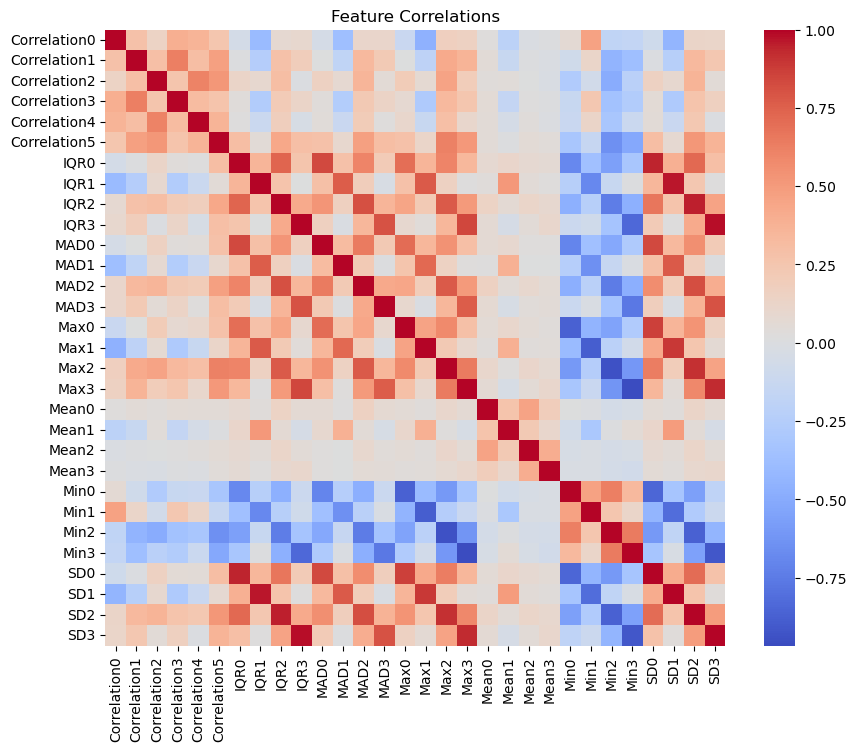

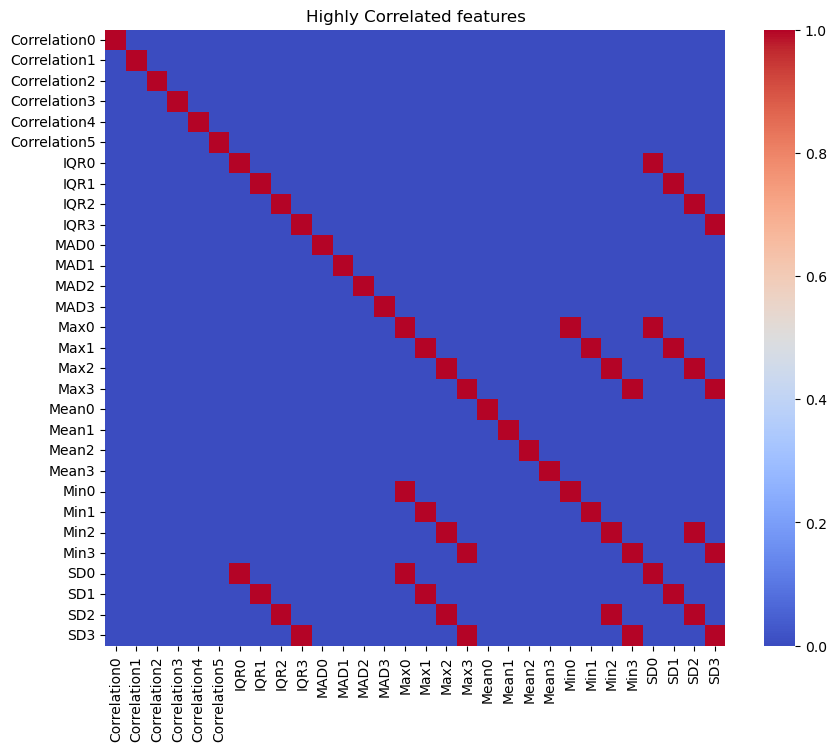

In [13]:
feature_corr_matrix = featured_df[stats_features].corr() 
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `stats` feature pairs

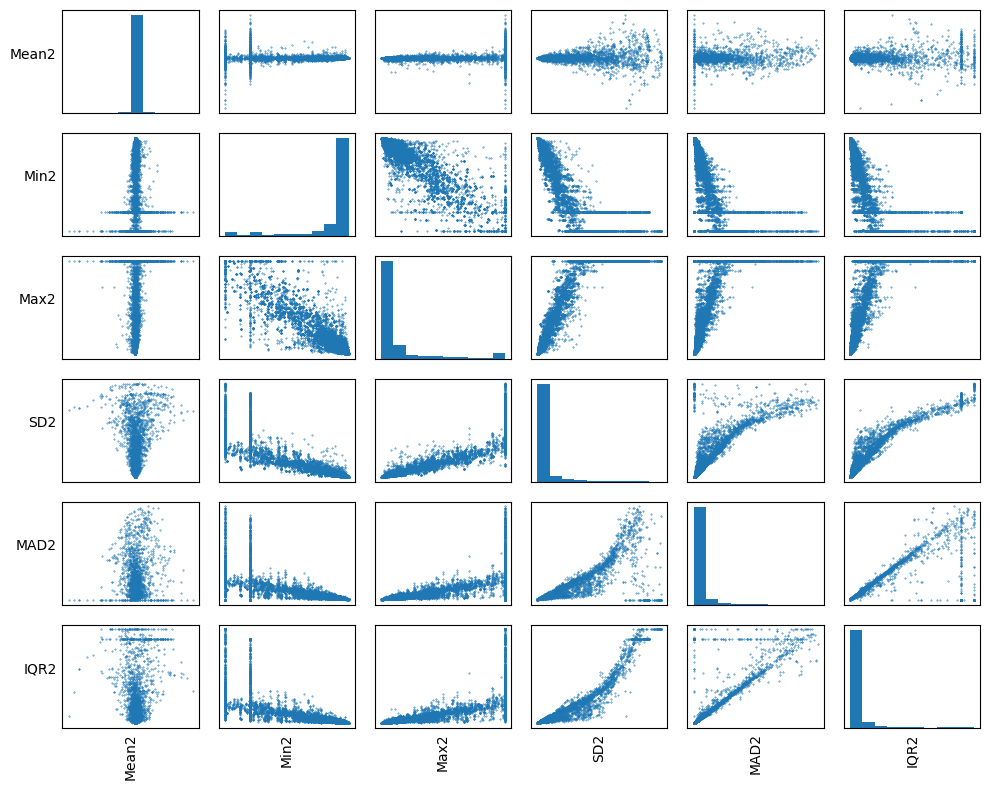

In [14]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
for ch in [2]:
    tmp_features = [ plate % ch for plate in ['Mean%d','Min%d','Max%d','SD%d', 'MAD%d', 'IQR%d']]
    scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


## `info` features



Text(0.5, 1.0, 'Highly Correlated features')

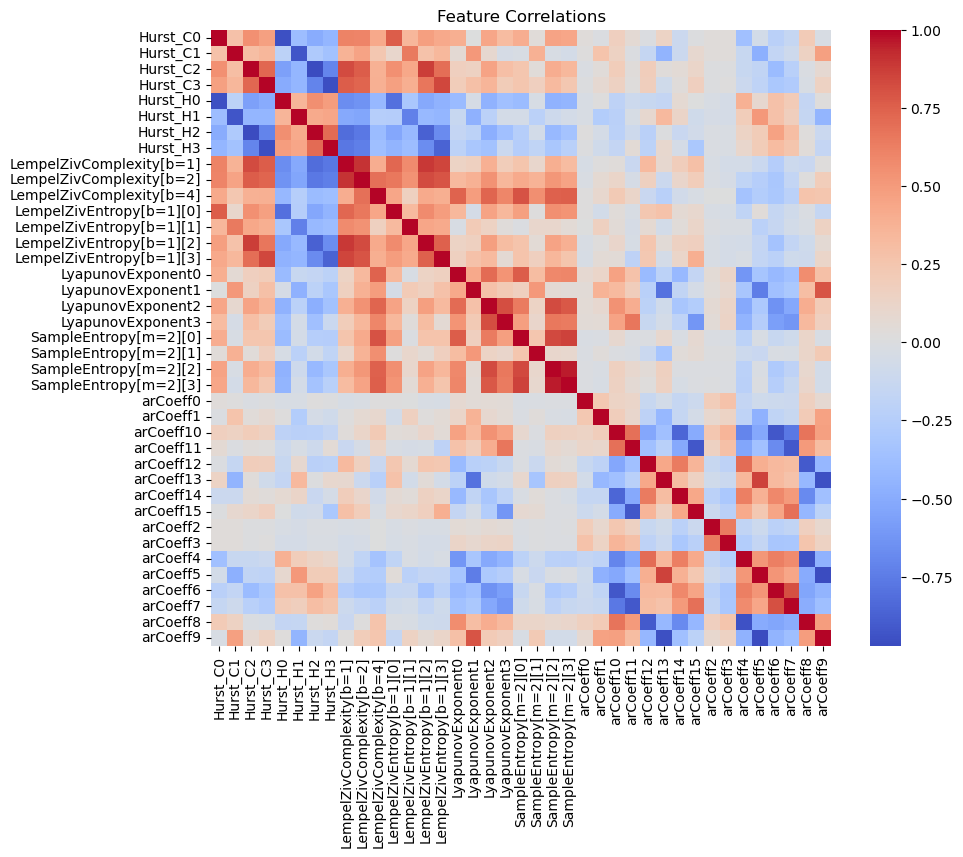

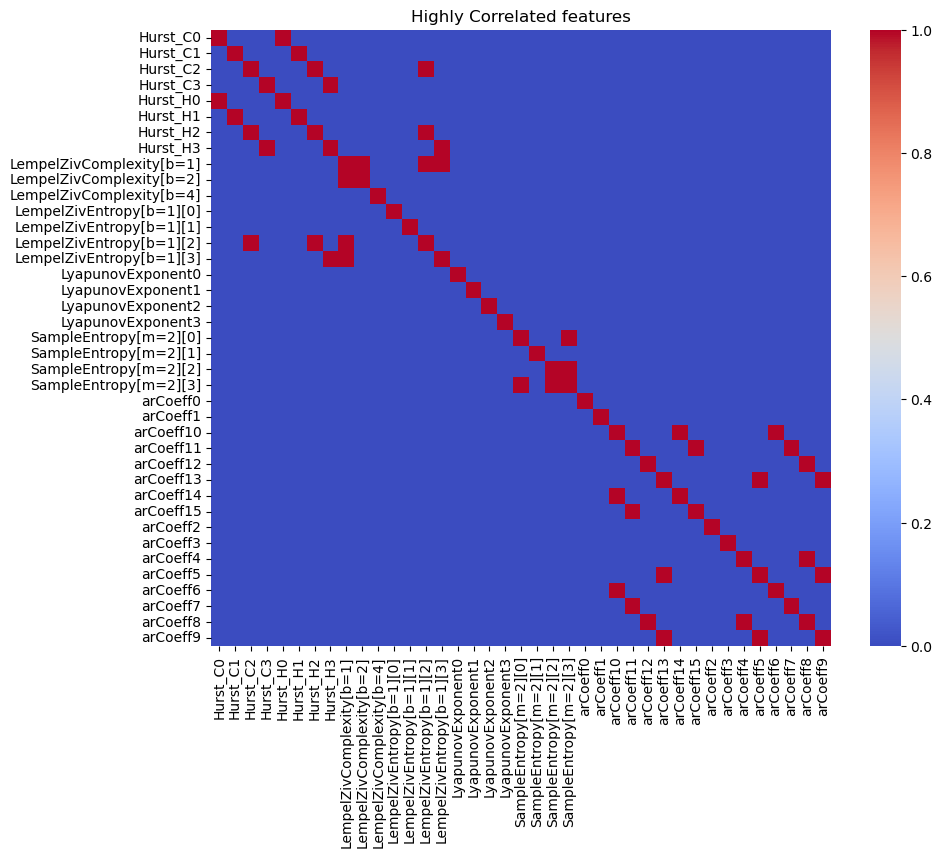

In [15]:

feature_corr_matrix = featured_df[info_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `info` feature pairs

In [16]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'SD0', 'SD1', 'SD2', 'SD3', 'MAD0', 'MAD1', 'MAD2', 'MAD3',
       'Max0', 'Max1', 'Max2', 'Max3', 'Min0', 'Min1', 'Min2', 'Min3',
       'Energy0', 'Energy1', 'Energy2', 'Energy3', 'IQR0', 'IQR1', 'IQR2',
       'IQR3', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3',
       'Correlation4', 'Correlation5', 'MaxFreqInd0', 'MaxFreqInd1',
       'MaxFreqInd2', 'MaxFreqInd3', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2',
       'MeanFreq3', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2',
       'FreqSkewness3', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2',
       'FreqKurtosis3', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3',
       'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9',
       'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14',
       'arCoeff15', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent

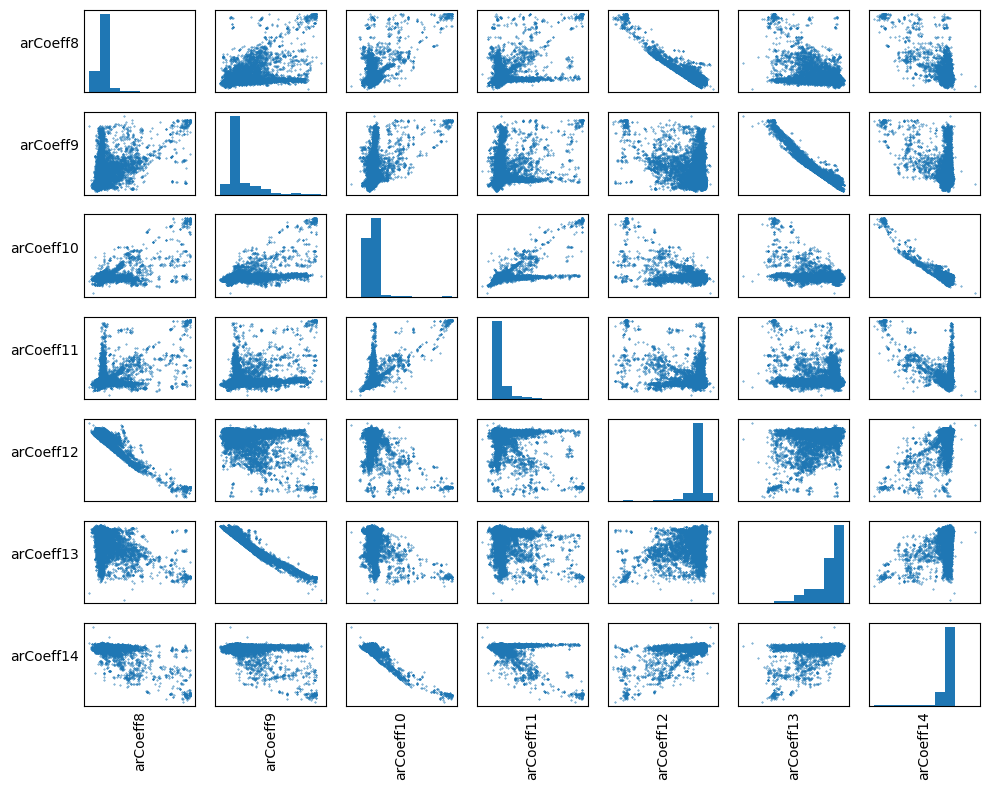

In [17]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f'arCoeff{d}' for d in range(8,15) ]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


tmp_features = ['SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]', 'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]']


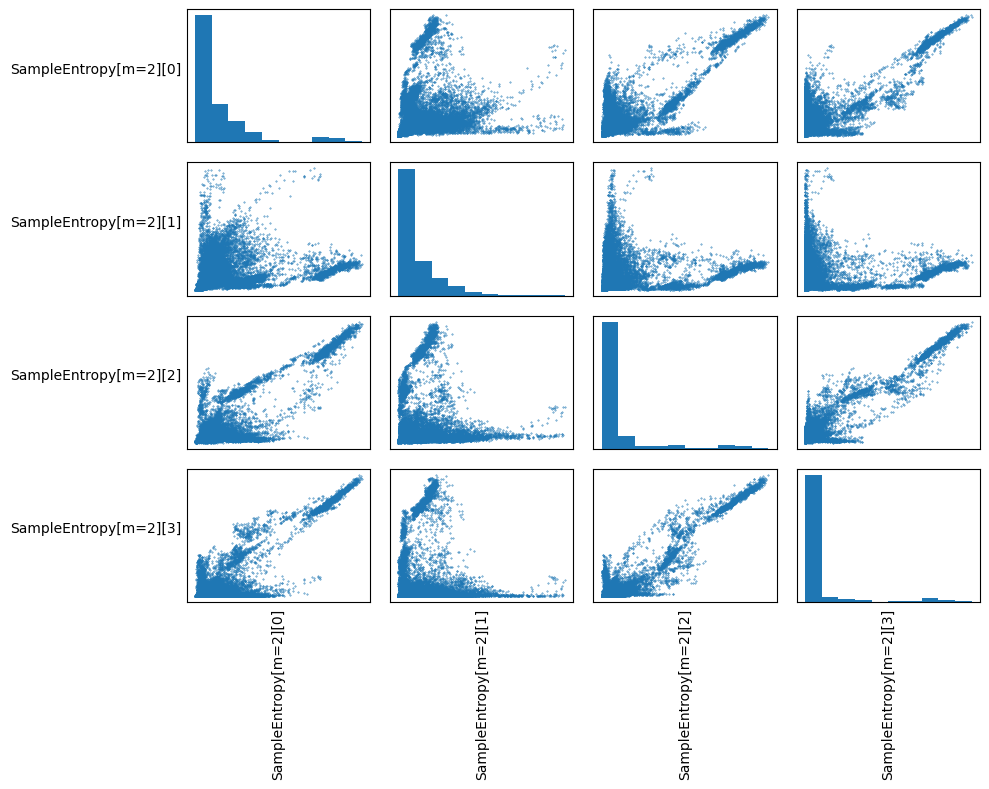

In [18]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('SampleEntropy') ][:5]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


tmp_features = ['Hurst_H0', 'Hurst_H1', 'Hurst_H2', 'Hurst_H3', 'Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3']


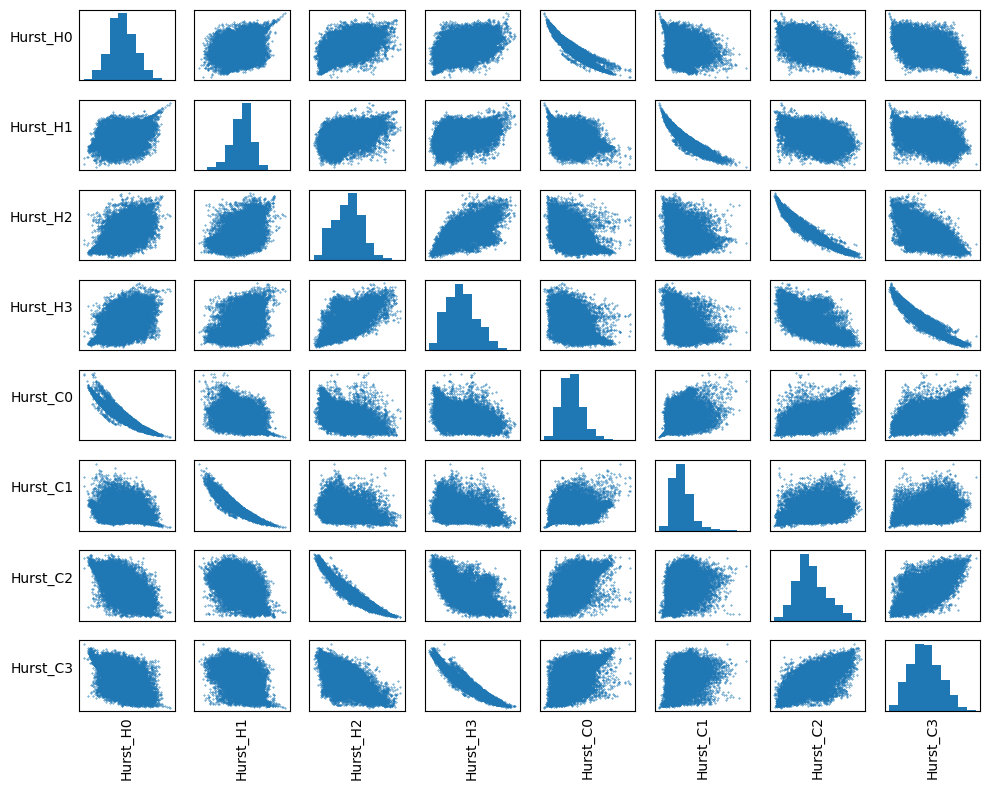

In [19]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ f for f in featured_df.columns if f.startswith('Hurst') ]
print(f"tmp_features = {tmp_features}")
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


In [20]:
featured_df.columns

Index(['participant', 'condition', 'window index', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'SD0', 'SD1', 'SD2', 'SD3', 'MAD0', 'MAD1', 'MAD2', 'MAD3',
       'Max0', 'Max1', 'Max2', 'Max3', 'Min0', 'Min1', 'Min2', 'Min3',
       'Energy0', 'Energy1', 'Energy2', 'Energy3', 'IQR0', 'IQR1', 'IQR2',
       'IQR3', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3',
       'Correlation4', 'Correlation5', 'MaxFreqInd0', 'MaxFreqInd1',
       'MaxFreqInd2', 'MaxFreqInd3', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2',
       'MeanFreq3', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2',
       'FreqSkewness3', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2',
       'FreqKurtosis3', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3',
       'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9',
       'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14',
       'arCoeff15', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent

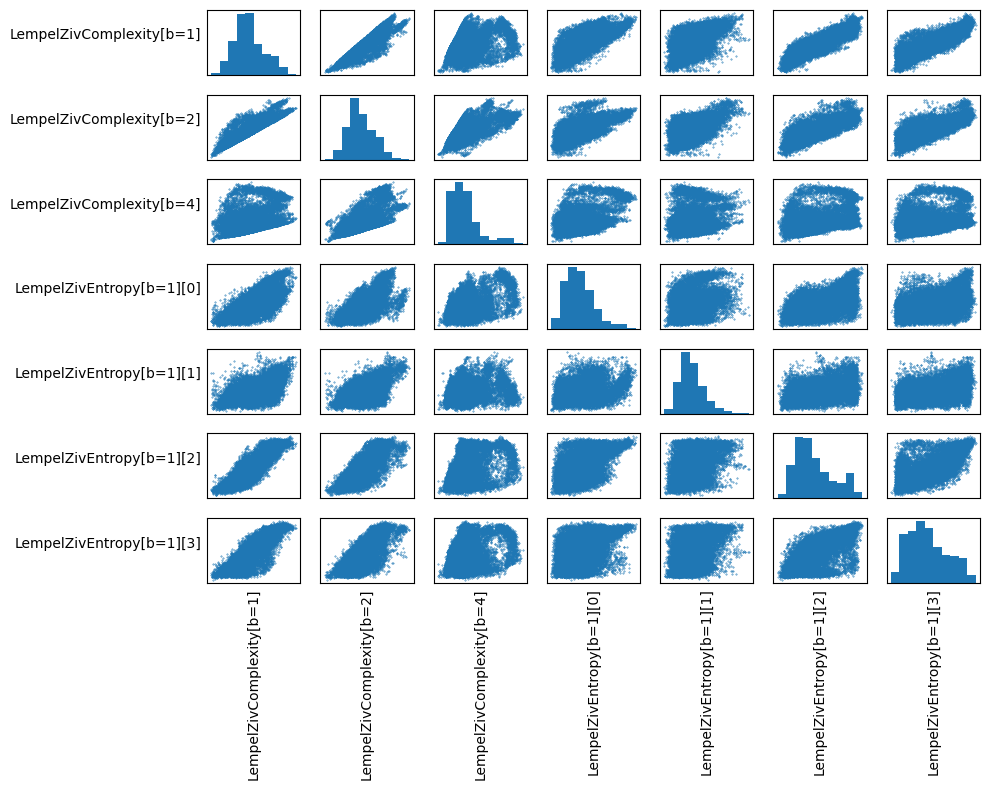

In [21]:
try:
    # entropy and complexity correlations
    # for ch in [0,1,2,3]:
    tmp_features = [ f for f in featured_df.columns if f.startswith('LempelZiv') ]
    tmp_features.sort()
    scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)
except:
    print("Skipping correlation analysis as not enough features")

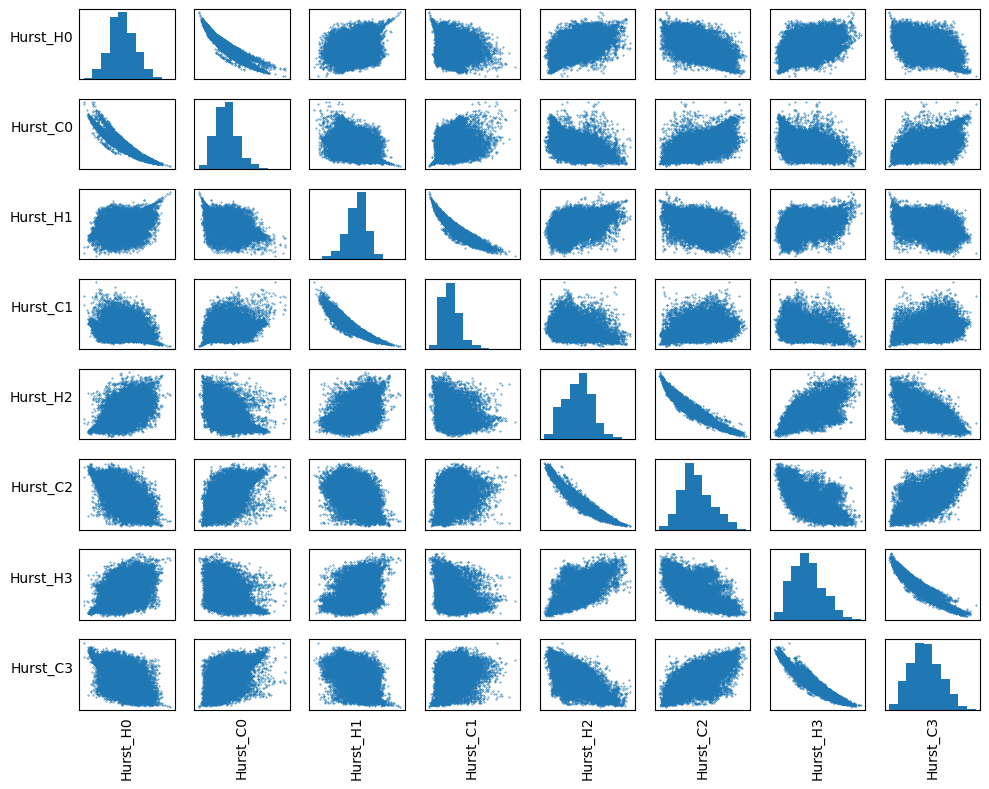

In [22]:
# entropy and complexity correlations
# for ch in [0,1,2,3]:
tmp_features = [ plate % ch for ch in range(4) for plate in ['Hurst_H%d','Hurst_C%d'] ]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


## `freq` features


Text(0.5, 1.0, 'Highly Correlated features')

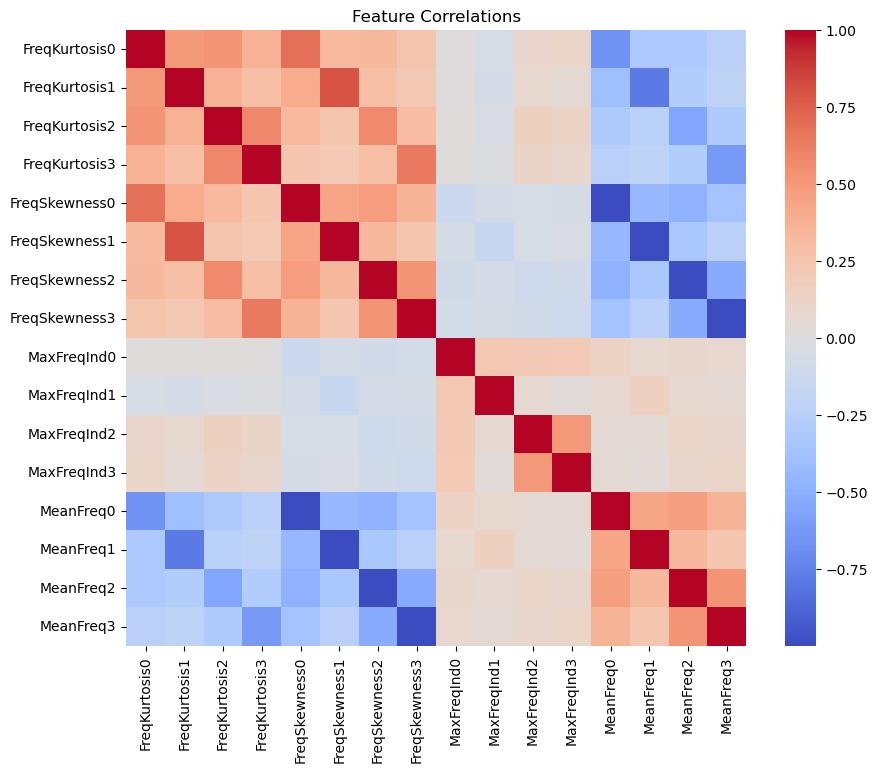

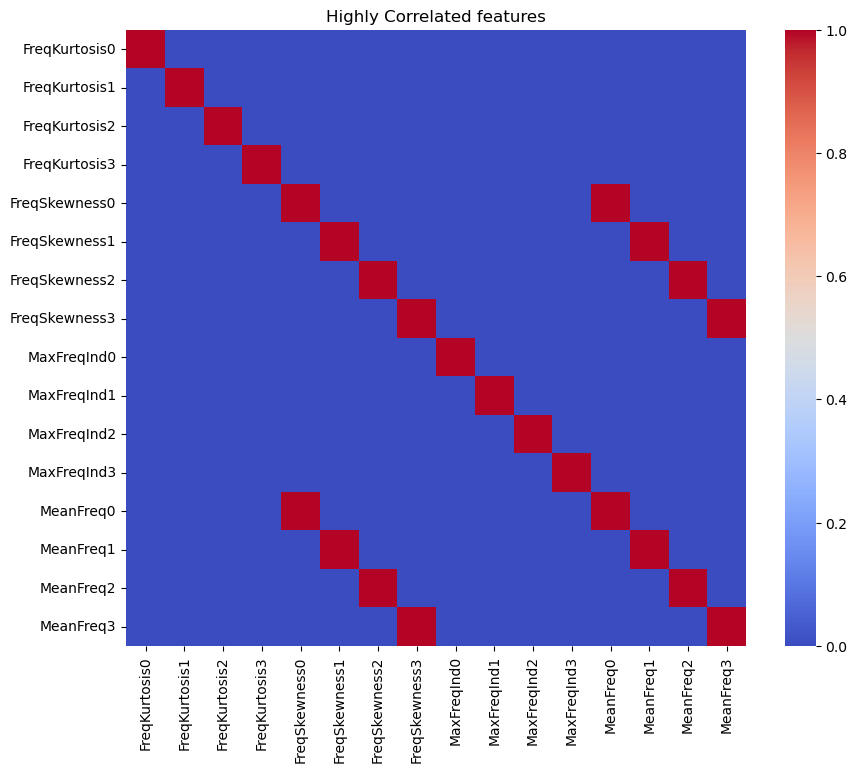

In [23]:

feature_corr_matrix = featured_df[freq_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Feature Correlations")

high_corr_threshold = 0.85
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(feature_corr_matrix) >= high_corr_threshold, cmap='coolwarm', annot=False)
plt.title(f"Highly Correlated features")


### Inspecting highly correlating `stats` feature pairs

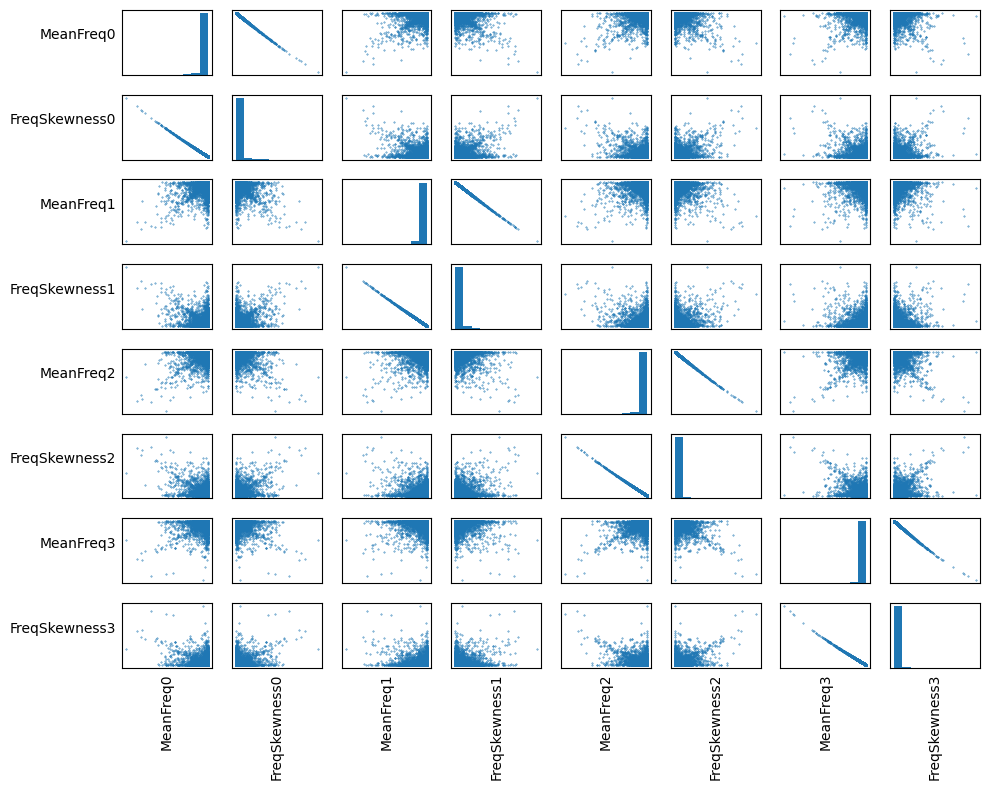

In [24]:
# entropy and complexity correlations
tmp_features = [ plate % ch for ch in [0,1,2,3] for plate in ['MeanFreq%d','FreqSkewness%d']]
scatter_plot_features(featured_df, tmp_features, with_jitter=False, jitter=1e-1)


# Density of highly correlated features 

### What proportion of our feature pairs overall are highly correlated 

Text(0.5, 1.0, 'Proportion of non-reflexive pairs more correlated than some threshold')

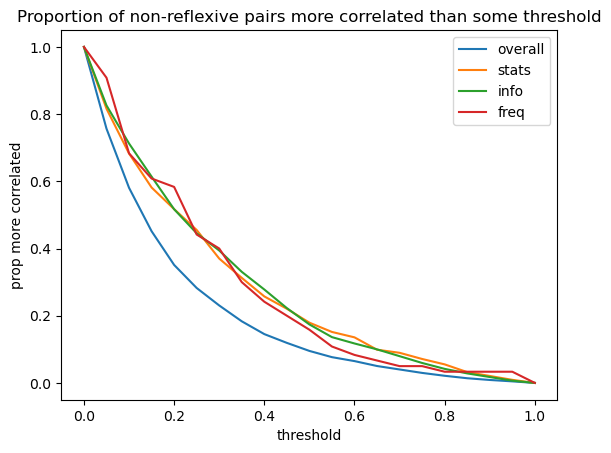

In [25]:

for tmp_features, group_name in [
        ( featured_df.columns, 'overall'), (stats_features,'stats'),
        (info_features, 'info'), (freq_features, 'freq')]:
    feature_corr_matrix = featured_df[tmp_features].corr()
    thresholds = np.linspace(0,1,21)
    num_more_correlated = np.empty(thresholds.size, dtype=int)
    for t,thresh in enumerate(thresholds):
    #     print(f"thresh = {thresh}")
        pairs = [(i,j) for i, j in zip(*np.where(np.abs(feature_corr_matrix) >= thresh)) if i != j]
        num_more_correlated[t] = len(pairs)
    prop_more_correlated = num_more_correlated /num_more_correlated[0]

    plt.plot(thresholds, prop_more_correlated, label=group_name)

plt.legend()
plt.xlabel('threshold')
plt.ylabel('prop more correlated')
plt.title("Proportion of non-reflexive pairs more correlated than some threshold")

## Feature correlations with conditions

In [26]:
conditions = np.unique(featured_df['condition'])
conditions
indep_conditions = []
for c in conditions:
    indep_condition = f'condition=={c}'
    featured_df[indep_condition] = featured_df['condition'] == c
    indep_conditions.append(indep_condition)

Text(0.5, 1.0, 'Label/Feature Correlations')

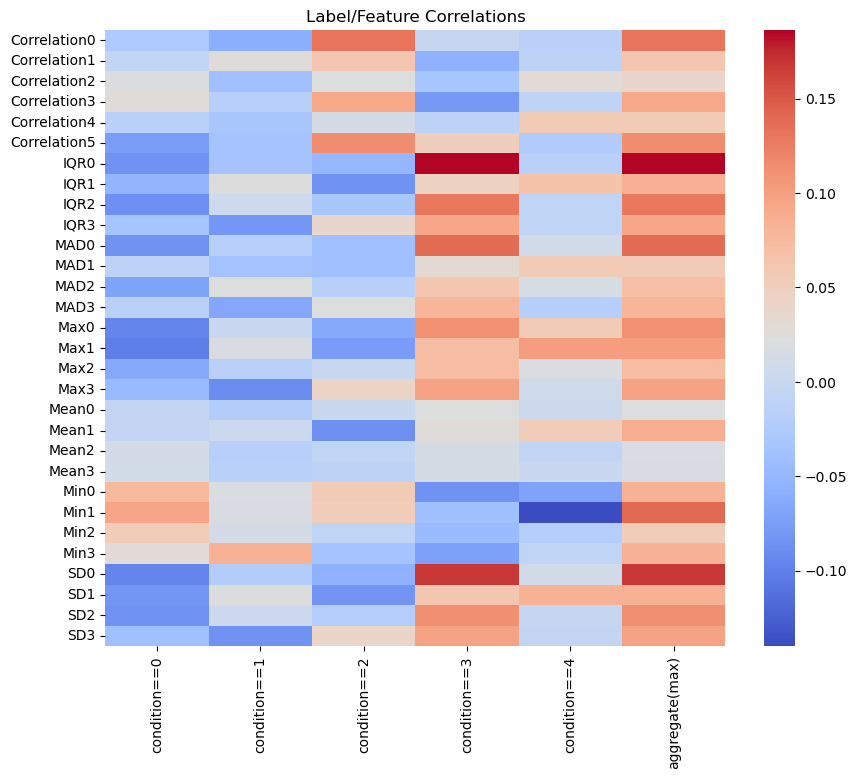

In [27]:
label_and_stats_features = indep_conditions + stats_features
feature_corr_matrix = featured_df[label_and_stats_features].corr()



feature_corr_matrix = feature_corr_matrix.loc[stats_features,indep_conditions]
feature_corr_matrix['aggregate(max)'] = np.max(np.abs(feature_corr_matrix.to_numpy()),axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


Text(0.5, 1.0, 'Label/Feature Correlations')

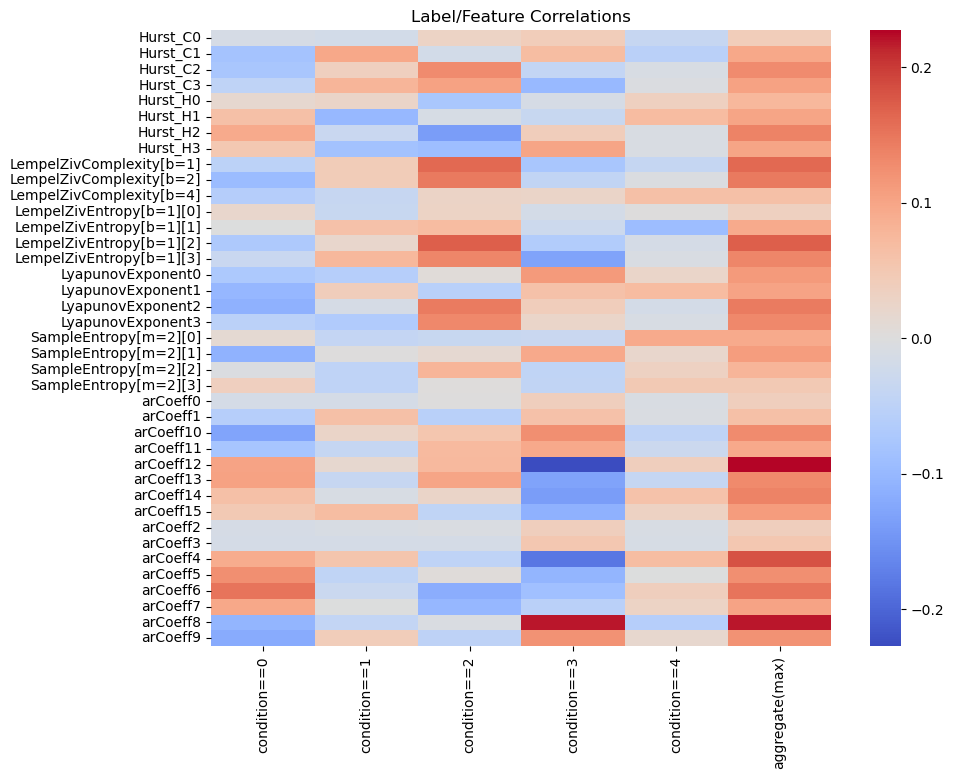

In [28]:
label_and_info_features = indep_conditions + info_features
feature_corr_matrix = featured_df[label_and_info_features].corr()

feature_corr_matrix = feature_corr_matrix.loc[info_features,indep_conditions]
#feature_corr_matrix['aggregate(mean)'] = np.mean(np.abs(feature_corr_matrix.to_numpy()),axis=1)
feature_corr_matrix['aggregate(max)'] = np.max(np.abs(feature_corr_matrix.to_numpy()),axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


Text(0.5, 1.0, 'Label/Feature Correlations')

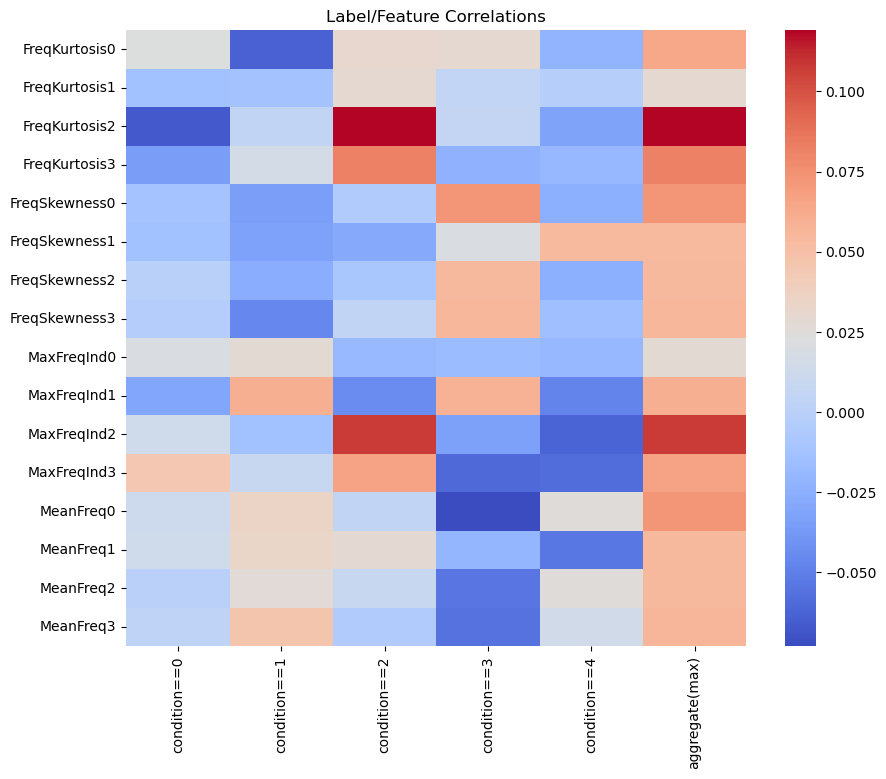

In [29]:
label_and_freq_features = indep_conditions + freq_features
feature_corr_matrix = featured_df[label_and_freq_features].corr()

feature_corr_matrix = feature_corr_matrix.loc[freq_features,indep_conditions]
feature_corr_matrix['aggregate(max)'] = np.max(np.abs(feature_corr_matrix.to_numpy()),axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


## Feature correlations with participant

In [30]:
participants = np.unique(featured_df['participant'])

indep_participants = []
for p in participants:
    indep_participant = f'participant=={p}'
    featured_df[indep_participant] = featured_df['participant'] == p
    indep_participants.append(indep_participant)

Text(0.5, 1.0, 'Label/Feature Correlations')

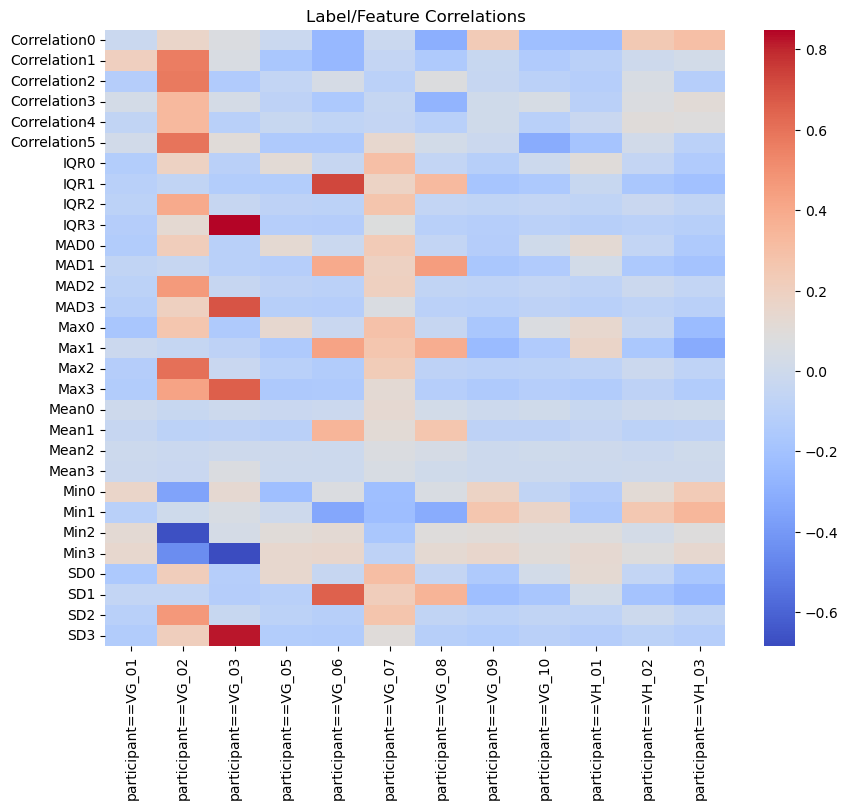

In [31]:
label_and_stats_features = indep_participants + stats_features
feature_corr_matrix = featured_df[label_and_stats_features].corr()

feature_corr_matrix = feature_corr_matrix.loc[stats_features,indep_participants]
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


Text(0.5, 1.0, 'Label/Feature Correlations')

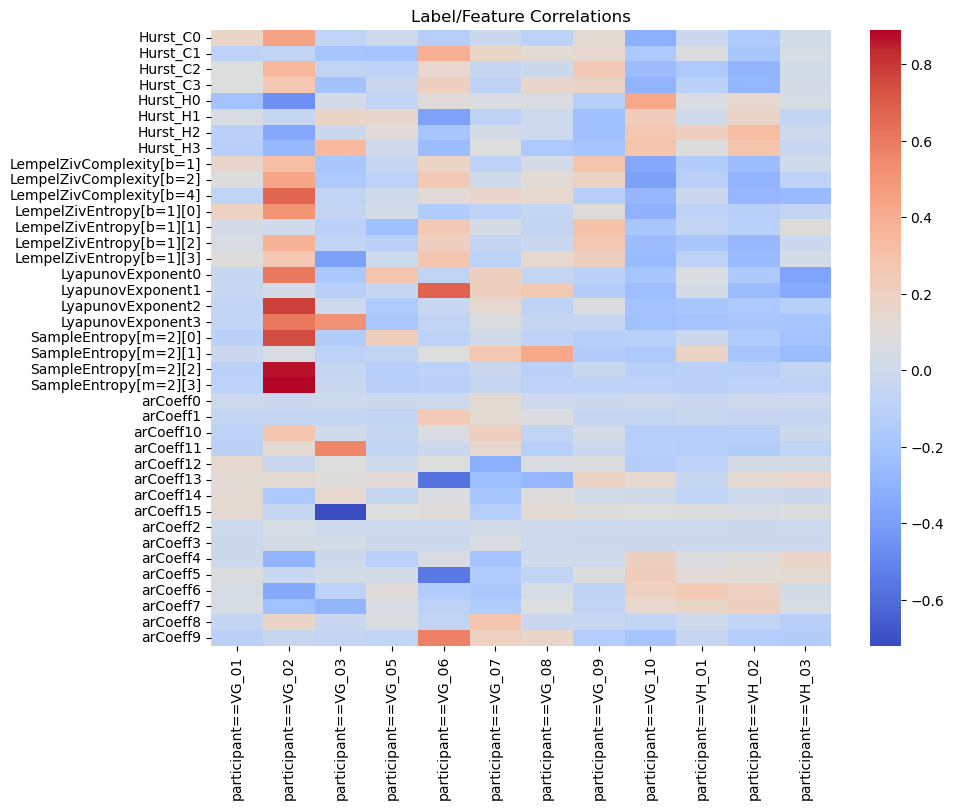

In [32]:
label_and_info_features = indep_participants + info_features
feature_corr_matrix = featured_df[label_and_info_features].corr()

feature_corr_matrix = feature_corr_matrix.loc[info_features,indep_participants]
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


Text(0.5, 1.0, 'Label/Feature Correlations')

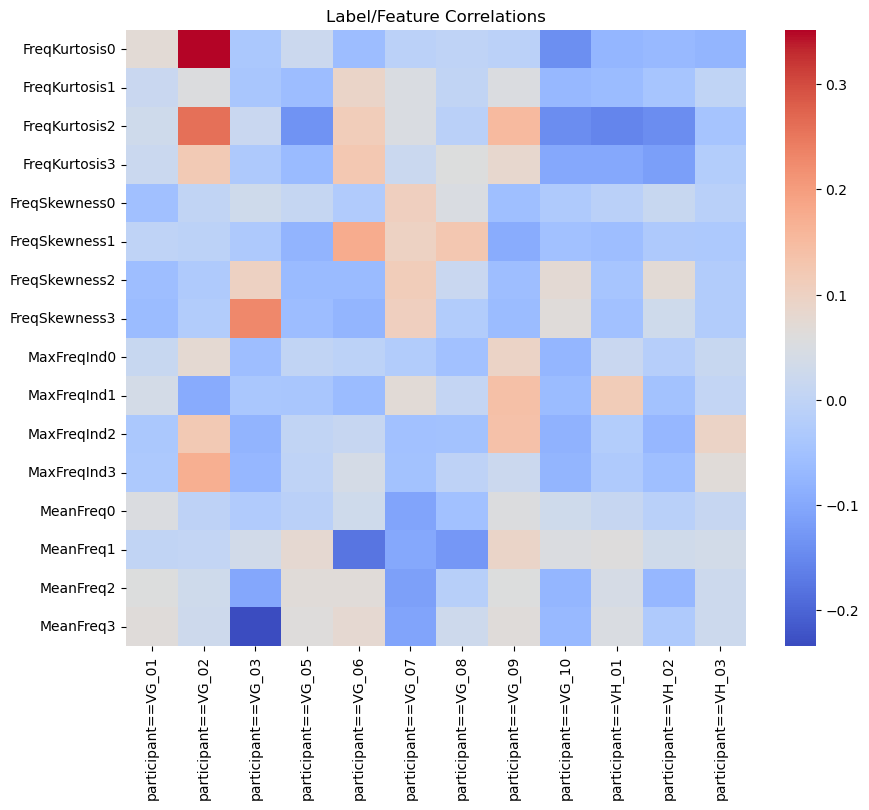

In [33]:
label_and_freq_features = indep_participants + freq_features
feature_corr_matrix = featured_df[label_and_freq_features].corr()

feature_corr_matrix = feature_corr_matrix.loc[freq_features,indep_participants]
plt.figure(figsize=(10,8))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', annot=False)
plt.title(f"Label/Feature Correlations")


## Inifinite values

In [34]:
df = pd.DataFrame({'a':[0,np.NaN, 0], 'b':[0, 0, 1]})
df = pd.concat([df]*3, ignore_index=True)   

%timeit df[df.apply(lambda x: x.isnull().all(), axis=1)]
%timeit df.loc[df.index.difference(df.dropna(how='all').index)]

1.61 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.3 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
df.index.difference(df.dropna(how='all').index)

RangeIndex(start=0, stop=0, step=1)

In [36]:
(pd.isna(featured_df[info_features]).any()==True).index

Index(['Hurst_C0', 'Hurst_C1', 'Hurst_C2', 'Hurst_C3', 'Hurst_H0', 'Hurst_H1',
       'Hurst_H2', 'Hurst_H3', 'LempelZivComplexity[b=1]',
       'LempelZivComplexity[b=2]', 'LempelZivComplexity[b=4]',
       'LempelZivEntropy[b=1][0]', 'LempelZivEntropy[b=1][1]',
       'LempelZivEntropy[b=1][2]', 'LempelZivEntropy[b=1][3]',
       'LyapunovExponent0', 'LyapunovExponent1', 'LyapunovExponent2',
       'LyapunovExponent3', 'SampleEntropy[m=2][0]', 'SampleEntropy[m=2][1]',
       'SampleEntropy[m=2][2]', 'SampleEntropy[m=2][3]', 'arCoeff0',
       'arCoeff1', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13',
       'arCoeff14', 'arCoeff15', 'arCoeff2', 'arCoeff3', 'arCoeff4',
       'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9'],
      dtype='object')

In [37]:
featured_df.loc[pd.isna(featured_df[stats_features])]

ValueError: Cannot index with multidimensional key

In [ ]:
featured_df.loc[:,['SampleEntropy[m=2][3]']].isna().any()

In [ ]:
with pd.set_option('mode.use_inf_as_na', True):
    featured_df[info_features].index[np.isinf(featured_df).any(1)]

In [ ]:
# https://stackoverflow.com/questions/42790542/find-row-positions-and-column-names-of-cells-contanining-inf-in-pandas-dataframe
df.columns.to_series()[np.isinf(df).any()]

In [ ]:
raise ValueError("Don't run the cell below")